In [120]:
%matplotlib inline
import math
from astropy.visualization import simple_norm
from multiprocessing import Value
import torch
from torch.utils.data import IterableDataset, DataLoader
import torchvision
import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams.update(mpl.rcParamsDefault)
from torchvision import transforms
import numpy as np
from skimage.segmentation import find_boundaries
import time
import h5py
import os
import pandas as pd
import ast
import sys
sys.path.append('../')
from utils.plotting_fns import cutout_rgb, find_percentile_from_target
from PIL import Image


_GLOBAL_SEED = 0

class MaskCollator(object):

    def __init__(
        self,
        input_size=(224, 224),
        patch_size=16,
        enc_mask_scale=(0.2, 0.8),
        pred_mask_scale=(0.2, 0.8),
        aspect_ratio=(0.3, 3.0),
        nenc=1,
        npred=2,
        min_keep=4,
        allow_overlap=False
    ):
        super(MaskCollator, self).__init__()
        if not isinstance(input_size, tuple):
            input_size = (input_size, ) * 2
        self.patch_size = patch_size
        self.height, self.width = input_size[0] // patch_size, input_size[1] // patch_size
        self.enc_mask_scale = enc_mask_scale
        self.pred_mask_scale = pred_mask_scale
        self.aspect_ratio = aspect_ratio
        self.nenc = nenc
        self.npred = npred
        self.min_keep = min_keep  # minimum number of patches to keep
        self.allow_overlap = allow_overlap  # whether to allow overlap b/w enc and pred masks
        self._itr_counter = Value('i', -1)  # collator is shared across worker processes
        self.generator = torch.Generator()  # Initialize a generator
        self.generator.manual_seed(int(time.time()))  # Seed the generator once

    def step(self):
        i = self._itr_counter
        with i.get_lock():
            i.value += 1
            v = i.value
        return v

    def _sample_block_size(self, generator, scale, aspect_ratio_scale):
        _rand = torch.rand(1, generator=generator).item()
        # -- Sample block scale
        min_s, max_s = scale
        mask_scale = min_s + _rand * (max_s - min_s)
        max_keep = int(self.height * self.width * mask_scale)
        # -- Sample block aspect-ratio
        min_ar, max_ar = aspect_ratio_scale
        aspect_ratio = min_ar + _rand * (max_ar - min_ar)
        # -- Compute block height and width (given scale and aspect-ratio)
        h = int(round(math.sqrt(max_keep * aspect_ratio)))
        w = int(round(math.sqrt(max_keep / aspect_ratio)))
        while h >= self.height:
            h -= 1
        while w >= self.width:
            w -= 1

        return (h, w)

    def _sample_block_mask(self, b_size, acceptable_regions=None):
        h, w = b_size

        def constrain_mask(mask, tries=0):
            """ Helper to restrict given mask to a set of acceptable regions """
            N = max(int(len(acceptable_regions)-tries), 0)
            for k in range(N):
                mask *= acceptable_regions[k]
        # --
        # -- Loop to sample masks until we find a valid one
        tries = 0
        timeout = og_timeout = 20
        valid_mask = False
        while not valid_mask:
            # -- Sample block top-left corner
            top = torch.randint(0, self.height - h + 1, (1,))
            left = torch.randint(0, self.width - w + 1, (1,))
            max_top = self.height - h
            max_left = self.width - w
            mask = torch.zeros((self.height, self.width), dtype=torch.int32)
            mask[top:top+h, left:left+w] = 1
            # -- Constrain mask to a set of acceptable regions
            if acceptable_regions is not None:
                constrain_mask(mask, tries)
            mask = torch.nonzero(mask.flatten())
            # -- If mask too small try again
            valid_mask = len(mask) > self.min_keep
            if not valid_mask:
                timeout -= 1
                if timeout == 0:
                    tries += 1
                    timeout = og_timeout
                    print(f'Mask generator says: "Valid mask not found, decreasing acceptable-regions [{tries}]"')
        mask = mask.squeeze()
        # --
        mask_complement = torch.ones((self.height, self.width), dtype=torch.int32)
        mask_complement[top:top+h, left:left+w] = 0
        # --
        return mask, mask_complement

    def __call__(self, batch):
        '''
        Create encoder and predictor masks when collating imgs into a batch
        # 1. sample enc block (size + location) using seed
        # 2. sample pred block (size) using seed
        # 3. sample several enc block locations for each image (w/o seed)
        # 4. sample several pred block locations for each image (w/o seed)
        # 5. return enc mask and pred mask
        '''
        collated_batch = torch.utils.data.default_collate(batch)
        
        if len(collated_batch) == 2:
            collated_images = collated_batch[0]
            collated_metadata = collated_batch[1]
        else:
            collated_images = collated_batch
            collated_metadata = torch.zeros(len(collated_batch))
        B = len(batch)
        
        seed = self.step()
        g = torch.Generator()
        g.manual_seed(seed)
        p_size = self._sample_block_size(
            generator=g,
            scale=self.pred_mask_scale,
            aspect_ratio_scale=self.aspect_ratio)
        e_size = self._sample_block_size(
            generator=g,
            scale=self.enc_mask_scale,
            aspect_ratio_scale=(1., 1.))

        collated_masks_pred, collated_masks_enc = [], []
        min_keep_pred = self.height * self.width
        min_keep_enc = self.height * self.width
        for _ in range(B):

            masks_p, masks_C = [], []
            for _ in range(self.npred):
                mask, mask_C = self._sample_block_mask(p_size)
                masks_p.append(mask)
                masks_C.append(mask_C)
                min_keep_pred = min(min_keep_pred, len(mask))
            collated_masks_pred.append(masks_p)

            acceptable_regions = masks_C
            
            try:
                if self.allow_overlap:
                    acceptable_regions = None
            except Exception as e:
                print(f'Encountered exception in mask-generator {e}')

            masks_e = []
            for _ in range(self.nenc):
                mask, _ = self._sample_block_mask(e_size, acceptable_regions=acceptable_regions)
                masks_e.append(mask)
                min_keep_enc = min(min_keep_enc, len(mask))
            collated_masks_enc.append(masks_e)

        collated_masks_pred = [[cm[:min_keep_pred] for cm in cm_list] for cm_list in collated_masks_pred]
        collated_masks_pred = torch.utils.data.default_collate(collated_masks_pred)
        # --
        collated_masks_enc = [[cm[:min_keep_enc] for cm in cm_list] for cm_list in collated_masks_enc]
        collated_masks_enc = torch.utils.data.default_collate(collated_masks_enc)

        return collated_images, collated_metadata, collated_masks_enc, collated_masks_pred

def load_images(batch_size=4, img_size=224):
    # Transform to normalize the data
    transform = transforms.Compose([
        transforms.Resize(img_size),
        transforms.ToTensor()
    ])
    
    # Load CIFAR10 images
    trainset = torchvision.datasets.CIFAR10(root='./data', train=True,
                                            download=True, transform=transform)
    trainloader = torch.utils.data.DataLoader(trainset, batch_size=batch_size,
                                              shuffle=True, num_workers=2)
    # Fetch one batch of images
    dataiter = iter(trainloader)
    images, _ = next(dataiter)
    return list(images)

def upscale_mask(mask, patch_size):
    upscaled_mask = mask.repeat_interleave(patch_size, dim=0)
    upscaled_mask = upscaled_mask.repeat_interleave(patch_size, dim=1)
    return upscaled_mask

def visualize_masks(
    images,
    masks_enc,
    masks_pred,
    patch_size,
    bands,
    alpha_grid=0.5,
    n_samples=5,
    patch_grid=False,
    savename=None,
    show_plot=False,
):
    # images = images.detach().cpu()
    # images = images[:n_samples]

    # height, width = images.shape[2], images.shape[3]

    # masks_enc = masks_enc[0].detach().cpu()
    # masks_enc = masks_enc[:n_samples]

    # masks_pred = torch.stack(masks_pred)
    # masks_pred = torch.unbind(masks_pred, dim=1)
    # # masks_pred = tuple(masks_p.detach().cpu() for masks_p in masks_pred)
    
    # masks_pred = masks_pred[:n_samples]

    # print(f'Shapes: images: {images.shape}, masks_enc: {masks_enc.shape}, len(masks_pred): {len(masks_pred)}, masks_pred[0].shape: {masks_pred[0].shape}')

    fig, axs = plt.subplots(nrows=len(images), ncols=3, figsize=(10, len(images) * 4))
    for i, (img, mask_indices_enc, mask_indices_pred) in enumerate(zip(images, masks_enc, masks_pred)):
        if images.shape[1] > 3:
            img = cutout_rgb(cutout=img, bands=bands, bands_rgb=['I', 'R', 'G'])
            img = np.asarray(img, dtype=np.int32)
            axs[i, 0].imshow(img)
        else:
            img = img.permute(1, 2, 0).detach().cpu().numpy()  # Change CxHxW to HxWxC for plotting
            axs[i, 0].imshow(img)

        axs[i, 0].set_xlim(0, img.shape[0])
        axs[i, 0].set_ylim(img.shape[1], 0)
        axs[i, 0].set_title('Original Image')
        axs[i, 0].axis('off')

        if patch_grid:
            for x in range(0, img.shape[0] + 1, patch_size):
                axs[i, 0].axvline(
                    x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed
            for y in range(0, img.shape[1] + 1, patch_size):
                axs[i, 0].axhline(
                    y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed

            for x in range(0, img.shape[0] + 1, patch_size):
                axs[i, 1].axvline(
                    x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed
            for y in range(0, img.shape[1] + 1, patch_size):
                axs[i, 1].axhline(
                    y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed

            for x in range(0, img.shape[0] + 1, patch_size):
                axs[i, 2].axvline(
                    x, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed
            for y in range(0, img.shape[1] + 1, patch_size):
                axs[i, 2].axhline(
                    y, color='black', linestyle='--', lw=0.2, alpha=alpha_grid
                )  # Adjust color and line style if needed

        full_mask = torch.zeros(height, width, dtype=torch.float32)
        print(f'full_mask.shape: {full_mask.shape}, img.shape: {img.shape}')
        for idx in mask_indices_enc:
            row = idx // height
            col = idx % width
            full_mask[row, col] = 1

        part_masks_p = torch.zeros(
            mask_indices_pred.shape[0],
            height,
            width,
            dtype=torch.float32,
        )
        for j, part_mask in enumerate(mask_indices_pred):
            for idx in part_mask:
                row = idx // height
                col = idx % width
                part_masks_p[j, row, col] = 1

        # Upscale mask to match image resolution
        full_mask = upscale_mask(full_mask, patch_size)

        part_masks_p = torch.stack([upscale_mask(sub_mask, patch_size) for sub_mask in part_masks_p])
        full_mask_p = torch.any(part_masks_p, dim=0)

        # Apply semi-transparent mask
        masked_img = img.copy()
        full_mask = full_mask
        alpha = 0.6  # transparency level

        if images.shape[1] == 5:
            axs[i, 1].imshow(masked_img)
        else:
            axs[i, 1].imshow(masked_img)
        axs[i, 1].imshow(np.ma.masked_where(full_mask == 1, full_mask), cmap='cool', vmin=-1, alpha=alpha)
        axs[i, 1].set_title('Final context mask')
        axs[i, 1].axis('off')

        masked_img_p = img.copy()
        full_mask_p = full_mask_p
        if images.shape[1] == 5:
            axs[i, 2].imshow(masked_img_p)
        else:
            axs[i, 2].imshow(masked_img_p)
        axs[i, 2].imshow(
            np.ma.masked_where(full_mask_p == 0, full_mask_p),
            cmap='cool',
            vmin=0,
            alpha=alpha,
            interpolation='none',
        )
        all_mask_boundaries = np.zeros(full_mask_p.shape, dtype='bool')
        for k in range(part_masks_p.shape[0]):
            mask_boundaries = find_boundaries(part_masks_p[k].detach().cpu().numpy(), mode='thin')
            all_mask_boundaries |= mask_boundaries
        axs[i, 2].imshow(
            np.ma.masked_where(all_mask_boundaries == 0, all_mask_boundaries),
            cmap='cool',
            vmin=1,
            alpha=alpha,
            interpolation='none',
        )
        axs[i, 2].set_title('Target masks')
        axs[i, 2].axis('off')

    if savename is not None:
        plt.savefig(
            savename,
            bbox_inches='tight',
            dpi=300,
        )
    if show_plot:
        plt.show()
    else:
        plt.close()

def read_h5(cutout_dir):
    """
    Reads cutout data from HDF5 file
    :param cutout_dir: cutout directory
    :return: cutout data
    """
    with h5py.File(cutout_dir, 'r') as f:
        # Create empty dictionaries to store data for each group
        cutout_data = {}

        # Loop through datasets
        for dataset_name in f:
            data = np.array(f[dataset_name])
            cutout_data[dataset_name] = data
    return cutout_data

class RealTileDataset(IterableDataset):
    def __init__(self, cutouts, metadata):
        """
        Initializes the dataset with real data.

        Args:
        cutouts (Tensor): A tensor or list of image data.
        metadata (Tensor): A tensor or list of corresponding metadata.
        """
        
        cutouts = torch.tensor(cutouts, dtype=torch.float32)
        self.cutouts = cutouts
        self.metadata = metadata

    def __iter__(self):
        for cutout, meta in zip(self.cutouts, self.metadata):
            yield cutout, meta

    def __len__(self):
        # Return the total number of items in the dataset
        return len(self.cutouts)

def convert_to_binary(input_string):
    # Define the standard order of letters
    standard_letters = 'ugriz'
    # Initialize the result as an empty string
    result = ''
    # Iterate over each letter in the standard order
    for letter in standard_letters:
        # Append '2' if the letter is in the input string, '1' otherwise
        if letter in input_string:
            result += '2'
        else:
            result += '1'
    # Convert the binary string to a decimal integer
    return np.int32(result)


def split_tile_nums(df):
    # Split the tuple into two separate columns
    if isinstance(df['tile'][0], str):
        df['tile'] = df['tile'].apply(ast.literal_eval)
    df['tile_num1'], df['tile_num2'] = zip(*df['tile'])
    # Drop tile column
    df.drop('tile', axis=1, inplace=True)
    return df


def tensor_compatible(df):
    # Convert band info to integer number, 2 -> present, 1 -> absent
    if isinstance(df['bands'][0], str):
        df['bands'] = df['bands'].apply(convert_to_binary)
    if 'tile' in df.columns:
        # Split tile numbers up to two different columns and delete the tile column
        df = split_tile_nums(df)
    return df

def get_band_indices(bands, bands_rgb):
    bands_full = ['G', 'I', 'R', 'Y', 'Z', 'NB0387', 'NB0816', 'NB0921', 'NB1010']
    band_idx = sorted([bands_full.index(band) for band in bands])
    band_idx_rgb = sorted([bands.index(band) for band in bands_rgb])
    if len(band_idx) == 0:
        logger.error('Band index list is empty.')
    return band_idx, band_idx_rgb

### Hyper Parameters

In [147]:
input_size=(64, 64)
patch_size=8
enc_mask_scale=(0.85, 1.0)
pred_mask_scale=(0.15, 0.2)
aspect_ratio=(0.75, 1.5)
nenc=1
npred=4
min_keep=5
height, width = input_size[0] // patch_size, input_size[1] // patch_size
alpha_grid = 0.5

In [148]:
height, width

(8, 8)

### Cutouts & Metadata

In [149]:
root = '/home/nick/astro/sky_embeddings/data'
cutouts = read_h5(os.path.join(root,'HSC_dud_simple_classifier_data_GIRYZ7610_64.h5'))
bands = ['G', 'I', 'R', 'Y', 'Z', 'NB0387', 'NB0816', 'NB0921', 'NB1010']
# catalog = pd.read_csv(os.path.join(root,'(146, 324)_catalog.csv'))

### Initialize Dataset

In [150]:
mask_collator = MaskCollator(
input_size=input_size,
patch_size=patch_size,
pred_mask_scale=pred_mask_scale,
enc_mask_scale=enc_mask_scale,
aspect_ratio=aspect_ratio,
nenc=nenc,
npred=npred,
allow_overlap=False,
min_keep=min_keep)
 
metadata = torch.from_numpy(np.column_stack((cutouts['ra'], cutouts['dec']))).to(torch.float32)

dataset = RealTileDataset(cutouts=cutouts['cutouts'], metadata=metadata)
dataloader = torch.utils.data.DataLoader(  # type: ignore
    dataset,
    batch_size=10,
    num_workers=0,
    pin_memory=True,
    drop_last=True,
    shuffle=False,
    collate_fn=mask_collator,
)

In [151]:
image_list = []
meta_list = []
mask_enc_list = []
mask_p_list = []

for i, (images, meta, masks_enc, masks_p) in enumerate(dataloader):
    image_list.append(images)
    meta_list.append(meta)
    mask_enc_list.append(masks_enc)
    mask_p_list.append(masks_p)
    print(f'shapes: images {images.shape}, metadata: {meta.shape}, mask_enc: {torch.stack(masks_enc).shape}, masks_pred: {torch.stack(masks_p).shape}')
    if i == 10:
        break

shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 13]), masks_pred: torch.Size([4, 10, 12])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 18]), masks_pred: torch.Size([4, 10, 12])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 14]), masks_pred: torch.Size([4, 10, 12])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 22]), masks_pred: torch.Size([4, 10, 9])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 17]), masks_pred: torch.Size([4, 10, 12])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 14]), masks_pred: torch.Size([4, 10, 12])
shapes: images torch.Size([10, 9, 64, 64]), metadata: torch.Size([10, 2]), mask_enc: torch.Size([1, 10, 12]), masks_pred: tor

In [152]:
images_in = load_images(batch_size=10, img_size=64)

mask_collator = MaskCollator(
input_size=input_size,
patch_size=patch_size,
pred_mask_scale=pred_mask_scale,
enc_mask_scale=enc_mask_scale,
aspect_ratio=aspect_ratio,
nenc=nenc,
npred=npred,
allow_overlap=False,
min_keep=min_keep)

Files already downloaded and verified


shapes: images: torch.Size([10, 3, 64, 64]), meta: torch.Size([10]), masks_enc: torch.Size([10, 19]), masks_p: torch.Size([4, 10, 12])
Shapes: images torch.Size([10, 3, 64, 64]), masks_enc: torch.Size([10, 19]), masks_pred torch.Size([4, 10, 12])
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)
full_mask.shape: torch.Size([8, 8]), img.shape: (64, 64, 3)


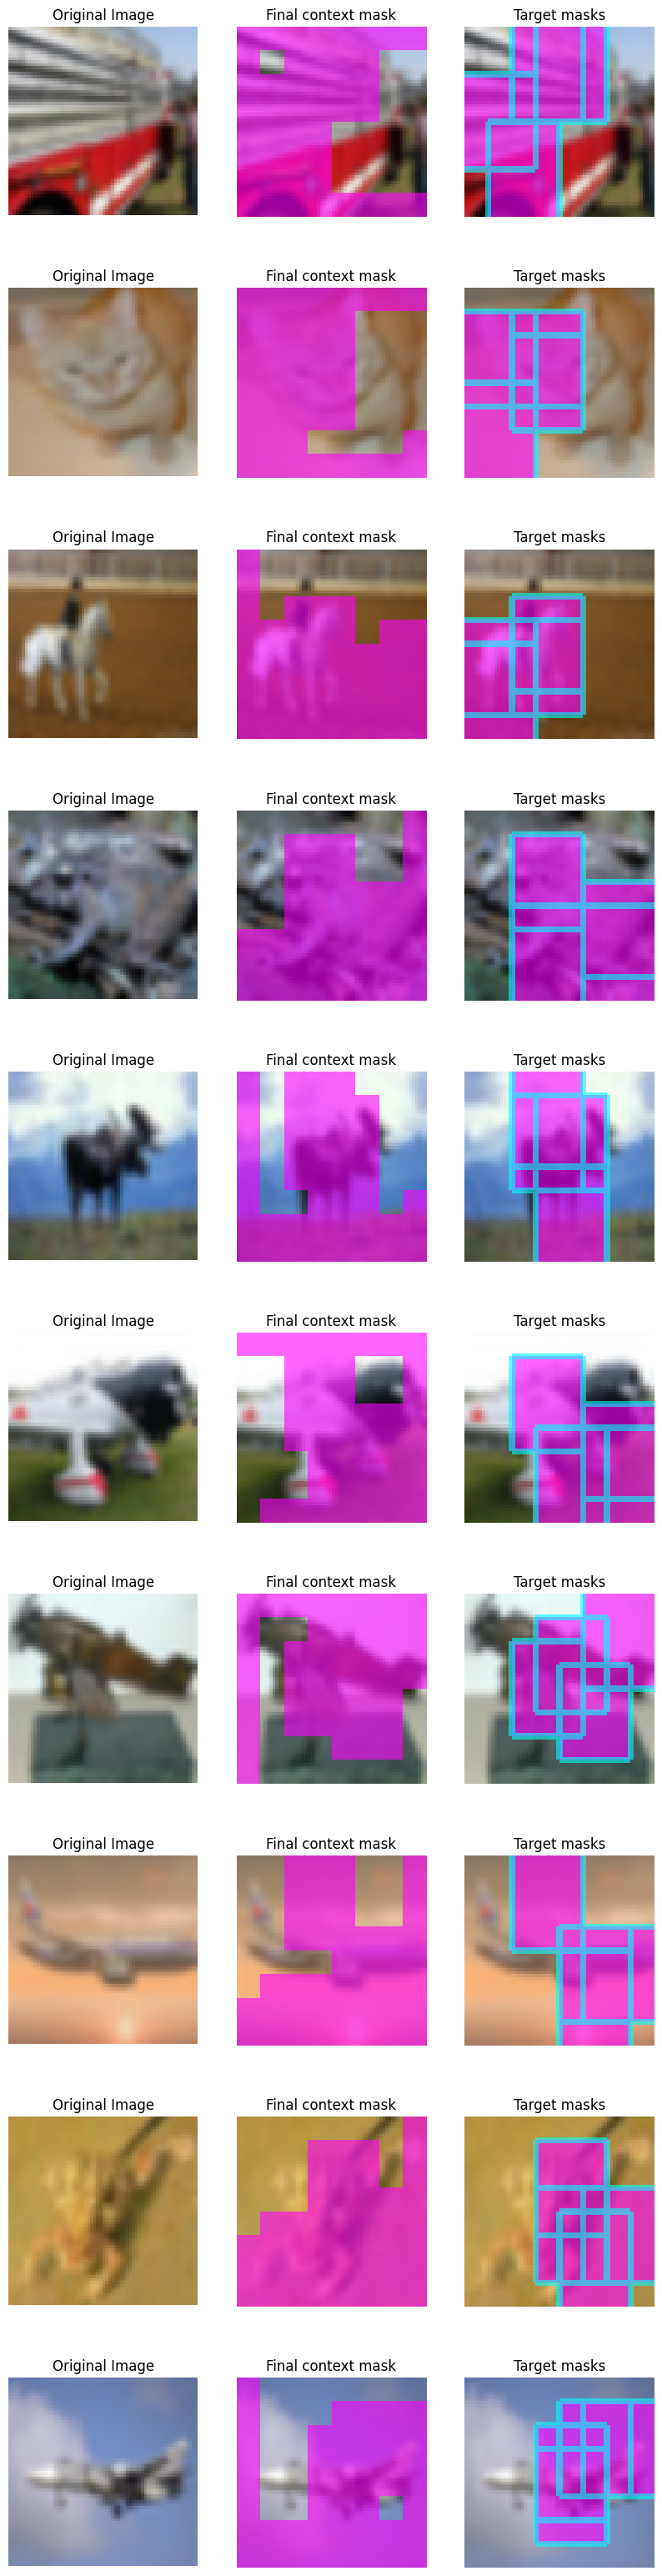

In [156]:
images, meta, masks_enc, masks_p = mask_collator(images_in)
print(f'shapes: images: {images.shape}, meta: {meta.shape}, masks_enc: {masks_enc[0].shape}, masks_p: {torch.stack(masks_p).shape}')
# idx = 1
# images, meta, masks_enc, masks_pred = image_list[idx], meta_list[idx], mask_enc_list[idx], mask_p_list[idx]
stacked_masks_p = torch.stack(masks_p)
reshaped_masks = torch.unbind(stacked_masks_p, dim=1)
# Just use one set of encoder masks for demonstration
print(f'Shapes: images {images.shape}, masks_enc: {masks_enc[0].shape}, masks_pred {torch.stack(masks_pred).shape}')
visualize_masks(images, masks_enc[0], reshaped_masks, patch_size, bands, alpha_grid, n_samples=5, patch_grid=False, show_plot=True)

In [89]:
reshaped_masks[0].shape

torch.Size([4, 132])

In [10]:
get_band_indices(bands, ['I','R','G'])[1]

[0, 1, 2]

In [14]:
images.shape

torch.Size([10, 9, 64, 64])

In [91]:
img_cpu = images.detach().cpu().numpy()

In [ ]:
images[:5].shape, masks_enc[0][:5].shape, reshaped_masks[:5]

In [94]:
img_cpu.shape, images.shape

((10, 9, 64, 64), torch.Size([10, 9, 64, 64]))

In [ ]:
images[0].shape

In [ ]:
plt.figure()
img_test = image_list[0][9].detach().cpu().numpy()
band_idx = 4
norm = simple_norm(img_test[band_idx], 'sqrt', percent=96.5)
plt.imshow(img_test[band_idx], cmap='gray_r', norm=norm, origin='lower')
plt.show()

In [ ]:
meta[1][3:5]

In [ ]:
images[0].detach().cpu().numpy().shape

In [ ]:
meta[1][3:5]